In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch

clean_df = pd.read_csv("../data/processed/cleaned_data.csv", sep=";")

sns.set_palette("rocket")

In [33]:
print("PYTORCH VERSION:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("MPS available:", torch.backends.mps.is_available())
print("MPS built:", torch.backends.mps.is_built())

if torch.cuda.is_available():
    print("CUDA device count:", torch.cuda.device_count())
    print("Current CUDA device:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(0))

if torch.backends.mps.is_available():
    print("Using device: MPS (Apple Silicon GPU)")
else:
    print("Using device: CPU")
    
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

device

PYTORCH VERSION: 2.9.1
CUDA available: False
MPS available: True
MPS built: True
Using device: MPS (Apple Silicon GPU)


device(type='mps')

In [34]:
price_ranges = [
    0,
    3_000,
    5_000,
    10_000,
    20_000,
    50_000,
    80_000,
    100_000,
    150_000,
    200_000,
    300_000,
    400_000,
    500_000,
    600_000,
    700_000,
    800_000,
    4_000_000,
]
df = clean_df.drop(
    [
        "url",
        "color",
        "posted_date",
        "price_net_info",
        "location",
        "price",
        "country_of_origin",
    ],
    axis=1,
    errors="ignore",
)

df["capacity"] = (
    df["capacity"]
    .str.replace(" cm3", "", regex=False)
    .str.replace(" ", "")
    .astype(float)
)

df["power"] = (
    df["power"].str.replace(" ", "").str.replace("KM", "", regex=False).astype(float)
)

df["mileage"] = (
    df["mileage"].str.replace(" km", "", regex=False).str.replace(" ", "").astype(float)
)

df["price_pln"] = (
    df["price_pln"].str.replace(" ", "").str.replace(",", ".").astype(float)
)

df = df.dropna(
    subset=[
        "model",
        "condition",
        "fuel",
        "brand",
        "body_type",
        "accident_free",
        "year",
        "capacity",
        "power",
        "mileage",
        "seats",
        "description",
    ]
)

In [4]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer


price_ranges = [
    0,
    3_000,
    5_000,
    10_000,
    20_000,
    50_000,
    80_000,
    100_000,
    150_000,
    200_000,
    300_000,
    400_000,
    500_000,
    600_000,
    700_000,
    800_000,
    4_000_000,
]

model_name = "allegro/herbert-klej-cased-v1"

tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-klej-cased-tokenizer-v1")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(price_ranges)
)

model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-klej-cased-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50560, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [5]:
class PriceDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        } | {
            "labels": torch.tensor(self.labels[idx])   # ← here labels[idx] is str
        }
        
    def __len__(self):
        return len(self.labels)

In [6]:
from sklearn.model_selection import train_test_split


X = df["description"].tolist()
y = pd.cut(df["price_pln"], bins=price_ranges, labels=False).astype(int).tolist()



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_enc = tokenizer(X_train, truncation=True, padding=True, max_length=256)
test_enc = tokenizer(X_test, truncation=True, padding=True, max_length=256)

In [7]:
from transformers import Trainer, TrainingArguments

train_dataset = PriceDataset(train_enc, y_train)
test_dataset = PriceDataset(test_enc, y_test)

training_args = TrainingArguments(
    output_dir='./model-training',
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

/Users/tomekogiolda/Projects/agh/sem-2/advanced-data-mining/project/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,1.678500
1000,1.412600
1500,1.198000
2000,1.105700
2500,0.947400
3000,0.857900
3500,0.726700


/Users/tomekogiolda/Projects/agh/sem-2/advanced-data-mining/project/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/tomekogiolda/Projects/agh/sem-2/advanced-data-mining/project/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/tomekogiolda/Projects/agh/sem-2/advanced-data-mining/project/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=3964, training_loss=1.0813940454323285, metrics={'train_runtime': 2293.5577, 'train_samples_per_second': 13.816, 'train_steps_per_second': 1.728, 'total_flos': 4169293001502720.0, 'train_loss': 1.0813940454323285, 'epoch': 4.0})

In [8]:
pred = trainer.predict(test_dataset)
pred_class = pred.predictions.argmax(axis=1)
print("Accuracy:", (pred_class == y_test).mean())

/Users/tomekogiolda/Projects/agh/sem-2/advanced-data-mining/project/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy: 0.6052498738011105


In [40]:
def predict(text):
    # tokenize a single string
    enc = tokenizer(
        [text],
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors="pt"
    )

    with torch.no_grad():
        outputs = model(**enc.to(model.device))
        probs = outputs.logits.softmax(dim=1)
        cls_id = probs.argmax(dim=1).item()
    

    return price_ranges[cls_id]

predict("ducato, silnik 3.0, rok 2001")


50000

accuracy: 0.6052498738011105

report:
               precision    recall  f1-score   support

           2       0.00      0.00      0.00         6
           3       0.43      0.21      0.28        62
           4       0.59      0.61      0.60       361
           5       0.56      0.64      0.60       346
           6       0.46      0.33      0.38       171
           7       0.69      0.69      0.69       410
           8       0.64      0.66      0.65       335
           9       0.65      0.73      0.69       193
          10       0.49      0.73      0.59        59
          11       0.00      0.00      0.00        23
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         6

    accuracy                           0.61      1981
   macro avg       0.32      0.33      0.32      1981
weighted avg       0.59      0.61      0.

/Users/tomekogiolda/Projects/agh/sem-2/advanced-data-mining/project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tomekogiolda/Projects/agh/sem-2/advanced-data-mining/project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tomekogiolda/Projects/agh/sem-2/advanced-data-mining/project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no 

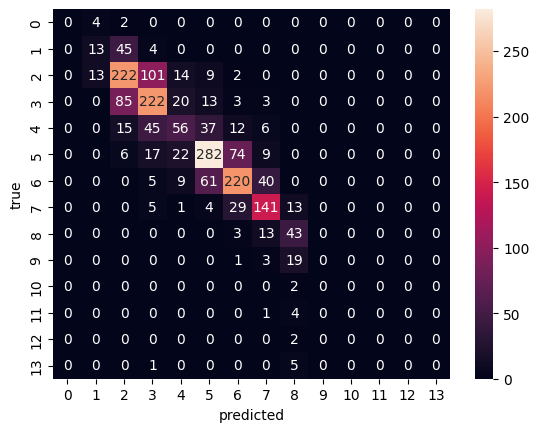

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


print("accuracy:", accuracy_score(y_test, pred_class))
print("\nreport:\n", classification_report(y_test, pred_class))

cm = confusion_matrix(y_test, pred_class)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()